In [105]:

import warnings
warnings.filterwarnings('ignore')

!pip install -q seaborn visualkeras
import visualkeras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go
from PIL import Image
import cv2
import os

import tensorflow as tf
from keras import layers
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model, load_model,save_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [43]:
!rm -r dataset

In [40]:
!kaggle datasets download -d asdasdasasdas/garbage-classification
!mv garbage-classification.zip garbage-classification1.zip

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 93% 76.0M/82.0M [00:00<00:00, 133MB/s]
100% 82.0M/82.0M [00:00<00:00, 103MB/s]


In [41]:
!kaggle datasets download -d mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 94% 225M/239M [00:01<00:00, 158MB/s]
100% 239M/239M [00:01<00:00, 125MB/s]


In [42]:
!kaggle datasets download -d quangtheng/garbage-classification-6-classes-775class

Dataset URL: https://www.kaggle.com/datasets/quangtheng/garbage-classification-6-classes-775class
License(s): Apache 2.0
 76% 38.0M/50.2M [00:00<00:00, 205MB/s]
100% 50.2M/50.2M [00:00<00:00, 208MB/s]


In [4]:
import os,zipfile

In [51]:
# os.mkdir('dataset')
# os.mkdir('dataset/garbage classification')
# os.mkdir('dataset/Garbage classification')
# os.mkdir('dataset/Garbage classification 6 classes')
dataset_dir = 'dataset'

In [52]:
target_file1 = 'garbage-classification1.zip'
target_file2 = 'garbage-classification.zip'
target_file3 = 'garbage-classification-6-classes-775class.zip'

In [58]:
extracting = zipfile.ZipFile(target_file1, 'r')
extracting.extractall(dataset_dir+'/garbage classification')
extracting.close()
extracting = zipfile.ZipFile(target_file2, 'r')
extracting.extractall(dataset_dir+'/Garbage classification')
extracting.close()
extracting = zipfile.ZipFile(target_file3, 'r')
extracting.extractall(dataset_dir+'/Garbage classification 6 classes')
extracting.close()

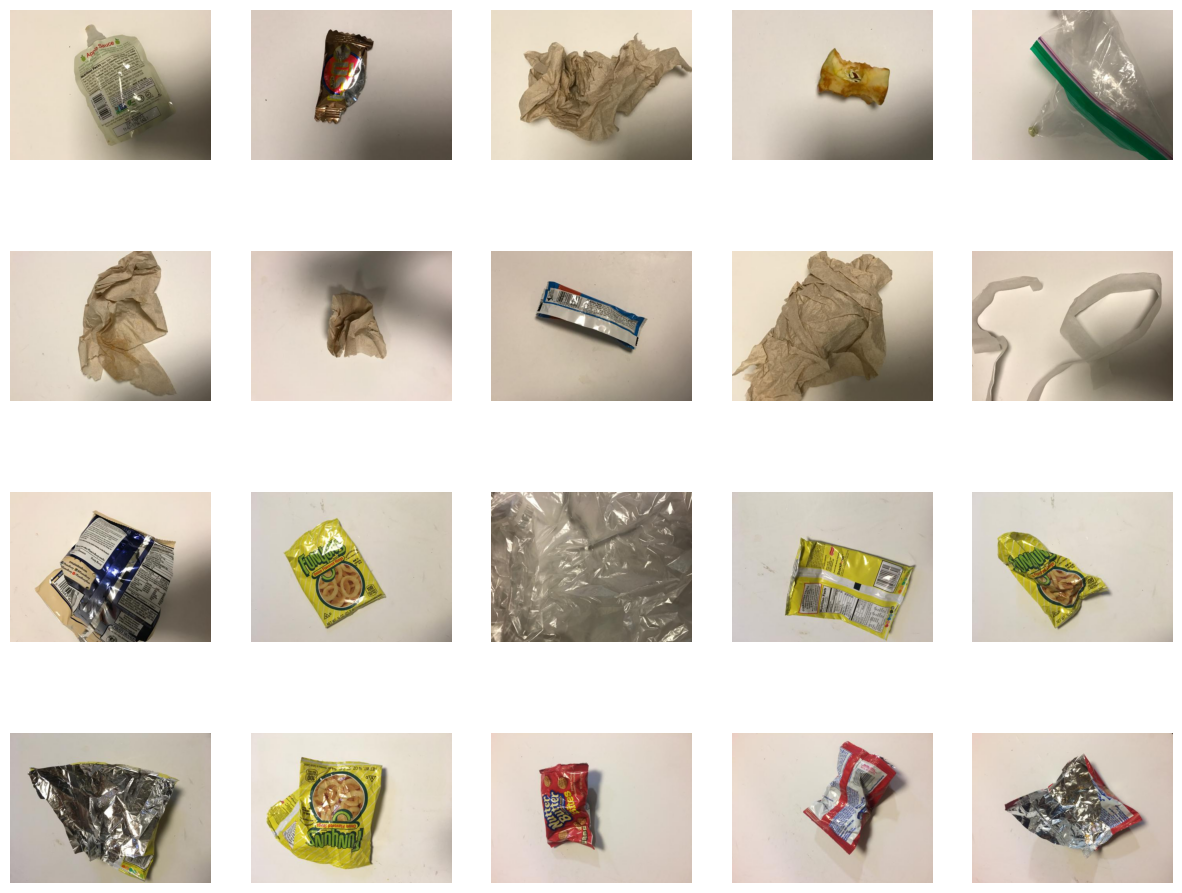

In [61]:
directory_path = f"{dataset_dir}/garbage classification/garbage classification/Garbage classification/trash"
image_files = sorted([file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])[:20]
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(directory_path, image_file))
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
plt.show()


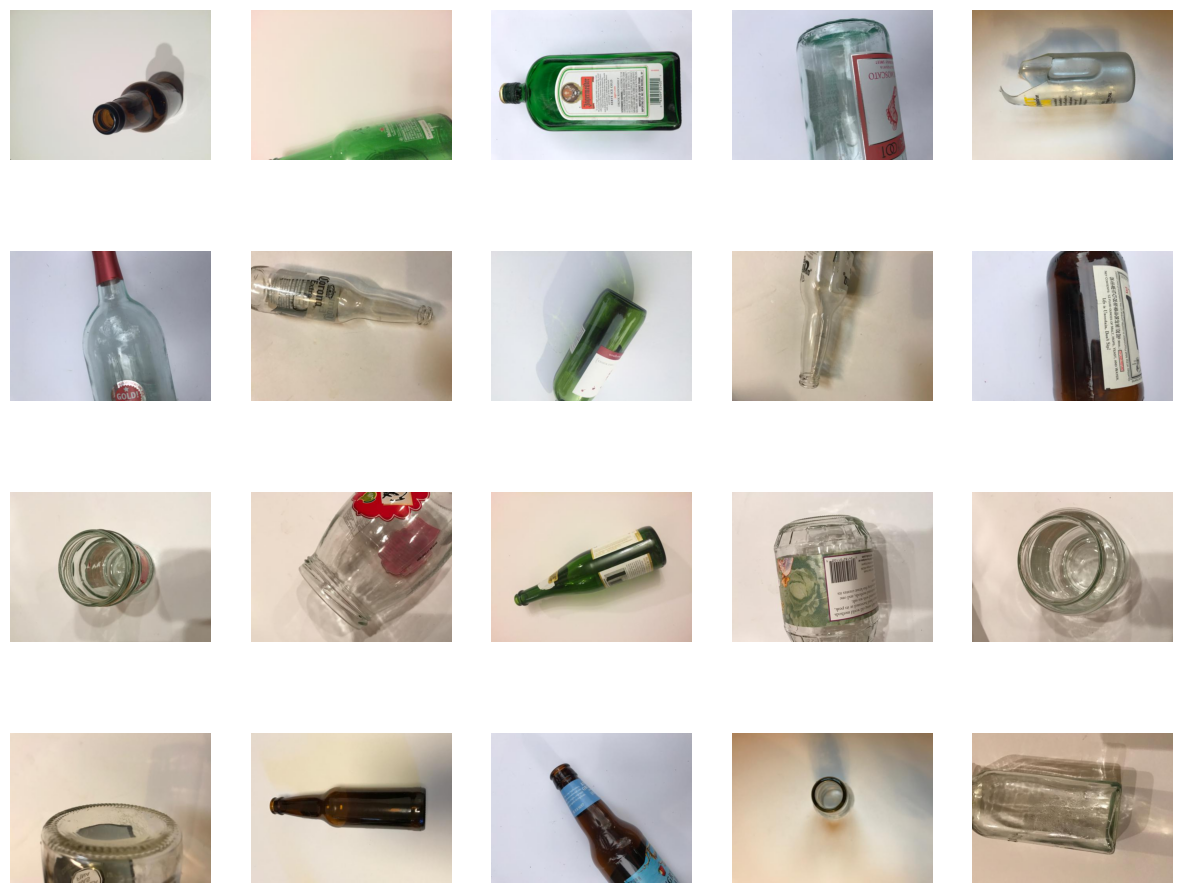

In [68]:
directory_path = f"{dataset_dir}/garbage classification/garbage classification/Garbage classification/glass"
image_files = sorted([file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])[:20]
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(directory_path, image_file))
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
plt.show()


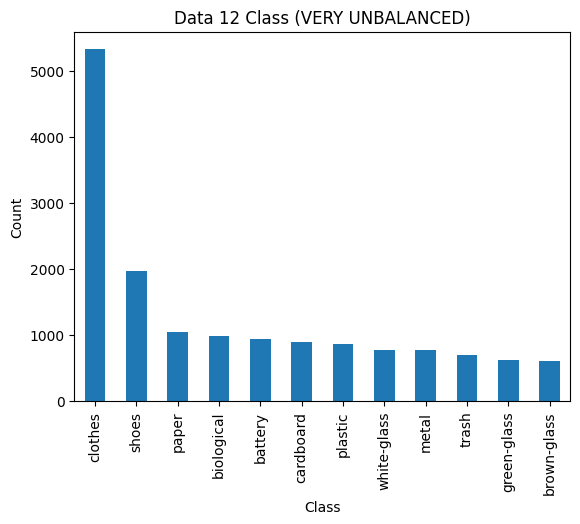

In [72]:
root = f'{dataset_dir}/Garbage classification/garbage_classification/'
data={}
for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i
data=pd.DataFrame(data.items(),columns=['path','class_'])
data['class_'].value_counts().plot(kind='bar')
plt.title('Data 12 Class (VERY UNBALANCED)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [73]:
data[data['class_'] == 'white-glass']['class_'].value_counts()


class_
white-glass    775
Name: count, dtype: int64

In [77]:
import shutil

original_path = f'{dataset_dir}/garbage classification/garbage classification/Garbage classification/'
bonus_data_path = f'{dataset_dir}/Garbage classification/garbage_classification/'
destination_path = 'content/'

if os.path.exists(destination_path) and os.path.isdir(destination_path):
    shutil.rmtree(destination_path)

os.makedirs(destination_path, exist_ok=True)
classes_to_remove = ['cardboard', 'trash', 'glass'] # in original data
new_classes = ['battery', 'biological', 'white-glass'] # in bonus data
target_image_count = 775

for class_name in os.listdir(original_path):
    class_path = os.path.join(original_path, class_name)

    if class_name in classes_to_remove:
        continue

    new_class_name = class_name
    if class_name in new_classes:
        new_class_name = new_classes[new_classes.index(class_name)]

    new_class_path = os.path.join(destination_path, new_class_name)
    os.makedirs(new_class_path, exist_ok=True)
    files_to_copy = os.listdir(class_path)[:target_image_count]
    for file_name in files_to_copy:
        file_path = os.path.join(class_path, file_name)
        shutil.copy(file_path, new_class_path)

    # If the class has fewer than target_image_count images, fill up from bonus data
    if len(os.listdir(new_class_path)) < target_image_count:
        remaining_images = target_image_count - len(os.listdir(new_class_path))
        print(f"{class_name} has {len(os.listdir(new_class_path))} images and missing {remaining_images} to fill {target_image_count}.")
        if class_name == "glass":
            bonus_class_path = os.path.join(bonus_data_path, "white-glass")
        else:
            bonus_class_path = os.path.join(bonus_data_path, class_name)
        if bonus_class_path:
            bonus_files = os.listdir(bonus_class_path)
            copied_names = set(os.listdir(new_class_path))
            for file_name in bonus_files:
                if remaining_images == 0:
                    break
                new_file_name = file_name
                counter = 1
                while new_file_name in copied_names:
                    base_name, extension = os.path.splitext(file_name)
                    new_file_name = f"{class_name}_{counter}{extension}"
                    counter += 1
                file_path = os.path.join(bonus_class_path, file_name)
                new_file_path = os.path.join(new_class_path, new_file_name)
                shutil.copy(file_path, new_file_path)
                copied_names.add(new_file_name)
                remaining_images -= 1

# Process the bonus dataset to copy battery and organic data
for class_name in os.listdir(bonus_data_path):
    class_path = os.path.join(bonus_data_path, class_name)
    if class_name in new_classes:
        new_class_name = class_name
        if class_name in new_classes:
            new_class_name = new_classes[new_classes.index(class_name)]
        if new_class_name == "biological":
            new_class_path = os.path.join(destination_path, "organic")
        elif new_class_name == "white-glass":
            new_class_path = os.path.join(destination_path, "glass")
        else:
            new_class_path = os.path.join(destination_path, new_class_name)
        os.makedirs(new_class_path, exist_ok=True)
        files_to_copy = os.listdir(class_path)[:target_image_count]
        for file_name in files_to_copy:
            file_path = os.path.join(class_path, file_name)
            shutil.copy(file_path, new_class_path)

print("\nFINISH: Dataset modification complete.")
for class_ in os.listdir(destination_path):
    count_class = len(os.listdir(os.path.join(destination_path, class_)))
    print(f"{class_} has {count_class} images.")


plastic has 482 images and missing 293 to fill 775.
metal has 410 images and missing 365 to fill 775.
paper has 594 images and missing 181 to fill 775.

FINISH: Dataset modification complete.
glass has 775 images.
plastic has 775 images.
battery has 775 images.
organic has 775 images.
metal has 775 images.
paper has 775 images.


In [79]:
data_path = f'{dataset_dir}/Garbage classification 6 classes/'
data_classes = os.listdir(data_path)
data_classes


['glass', 'plastic', 'battery', 'organic', 'metal', 'paper']

In [80]:
for class_ in os.listdir(data_path):
    count_class = 0
    for photo in os.listdir(data_path + class_):
        count_class += 1
    print(str(class_) + " has " + str(count_class) + " images.")

glass has 775 images.
plastic has 775 images.
battery has 775 images.
organic has 775 images.
metal has 775 images.
paper has 775 images.


In [81]:
data = pd.DataFrame()
for class_ in os.listdir(data_path):
    temp = pd.DataFrame()
    temp['path'] = np.nan
    temp['type_trash'] = class_
    i = 0
    for photo in os.listdir(data_path + class_):
        temp.loc[i, 'path'] = data_path + class_ + "/" + photo
        temp.loc[i, 'type_trash'] = class_
        i += 1
    data = pd.concat([data, temp], ignore_index=True)
    del temp
data.shape

(4650, 2)

In [82]:
data = data.sample(frac=1)
data.reset_index(drop=True, inplace=True)
data.head(3)

,path,type_trash
0,dataset/Garbage classification 6 classes/batte...,battery
1,dataset/Garbage classification 6 classes/paper...,paper
2,dataset/Garbage classification 6 classes/organ...,organic


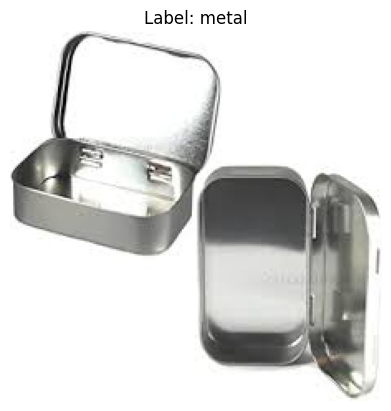

In [83]:
def display_images_with_labels(df, idx):
        row = df.iloc[idx]
        image_path = row['path']
        image_label = row['type_trash']
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(f'Label: {image_label}')
        plt.axis('off')
        plt.show()

display_images_with_labels(data, 1040)


In [84]:
from keras.applications.vgg16 import preprocess_input

def image_preprocessing(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

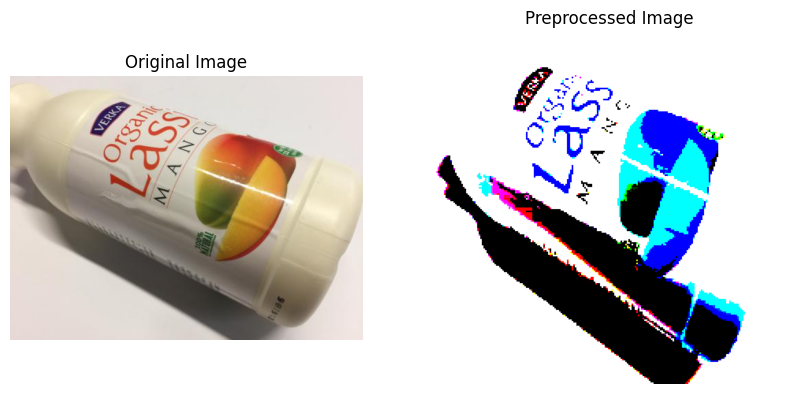

In [86]:
def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(np.squeeze(preprocessed, axis=0))
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')
    plt.show()

img_path = f'{dataset_dir}/Garbage classification 6 classes/plastic/plastic125.jpg'
original_image = Image.open(img_path)
preprocessed_image = image_preprocessing(img_path)
plot_images(original_image, preprocessed_image)

58889256/58889256 [==============================] - 1s 0us/step


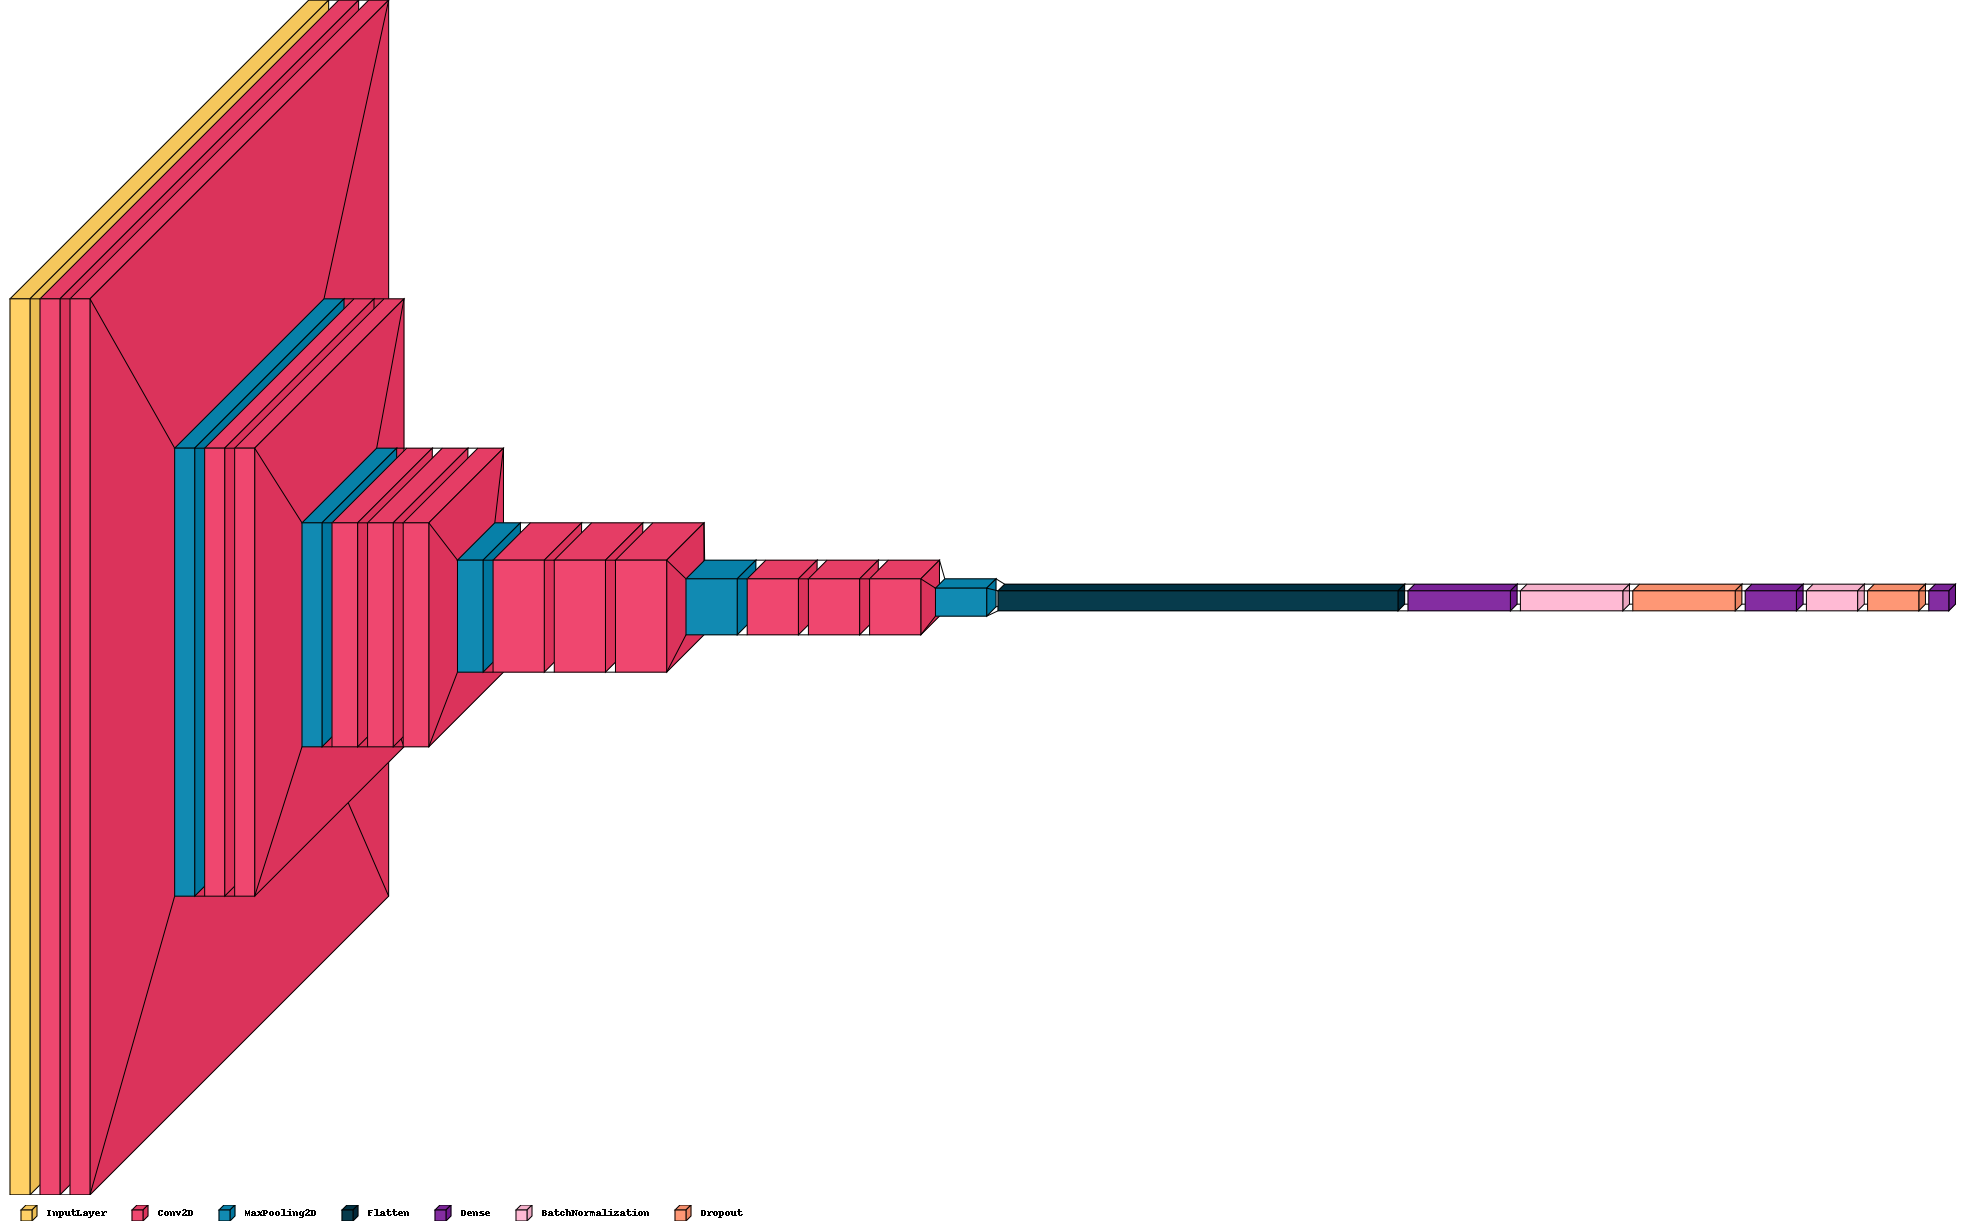

In [87]:
BATCH_SIZE = 64
n_classes = 6

# VGG16 base model
conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze all layers except the last two
for layer in conv_base.layers[:-2]:
    layer.trainable = False

# Fine-tune model
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(1024, activation='relu')(top_model)  # Increased units
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512, activation='relu')(top_model)  # Increased units
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = Model(inputs=conv_base.input, outputs=output_layer)
visualkeras.layered_view(model, to_file='model_architecture.png', legend=True)

In [88]:
def plot_random_images(generator, num_images=20):
    # Get a batch of data from the generator
    images, labels = next(generator)
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')

    plt.show()

Found 4650 images belonging to 6 classes.


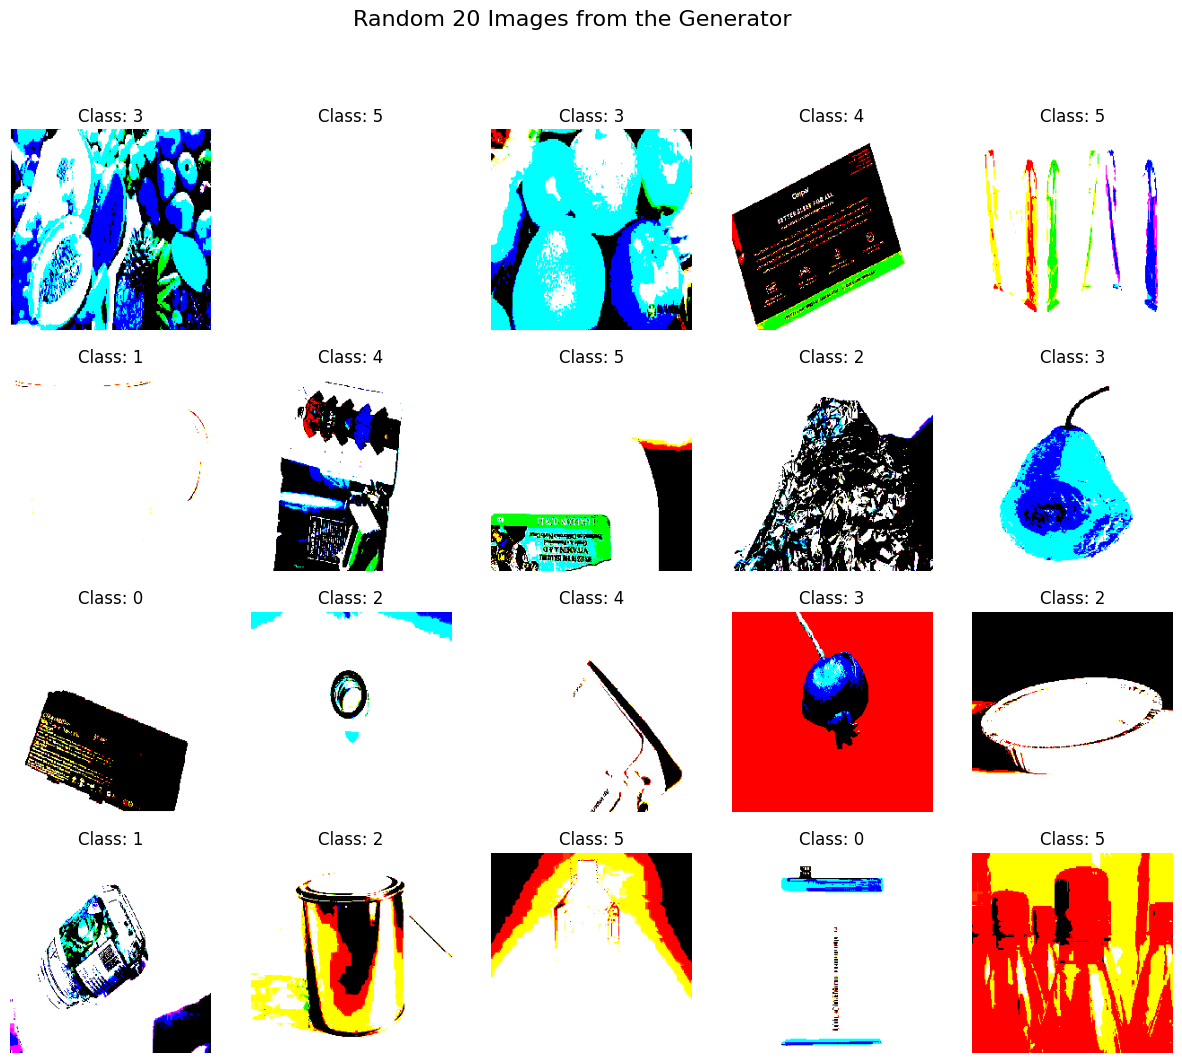

In [89]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
full_data = gen_train.flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(full_data)

In [132]:
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.1, random_state=42)

train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = gen_train.flow_from_dataframe(train_df, directory=data_path, target_size=(224, 224),
                                           batch_size=BATCH_SIZE, class_mode="categorical",
                                           shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(test_df, directory=data_path, target_size=(224, 224),
                                          batch_size=BATCH_SIZE, class_mode="categorical",
                                          shuffle=False)


Found 4185 validated image filenames belonging to 6 classes.
Found 465 validated image filenames belonging to 6 classes.


In [137]:
model.save(f"{dataset_dir}/garbage-classifier-model/garbage_classifier.vgg_16.h5")

In [141]:
model.save(f"{dataset_dir}/garbage-classifier-model/garbage_classifier.vgg_19.h5")

In [140]:
vgg16 = load_model(f"{dataset_dir}/garbage-classifier-model/garbage_classifier.vgg_16.h5")

In [142]:
output_class = ["battery", "glass", "metal","organic", "paper", "plastic"]

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

8/8 [==============================] - 310s 37s/step


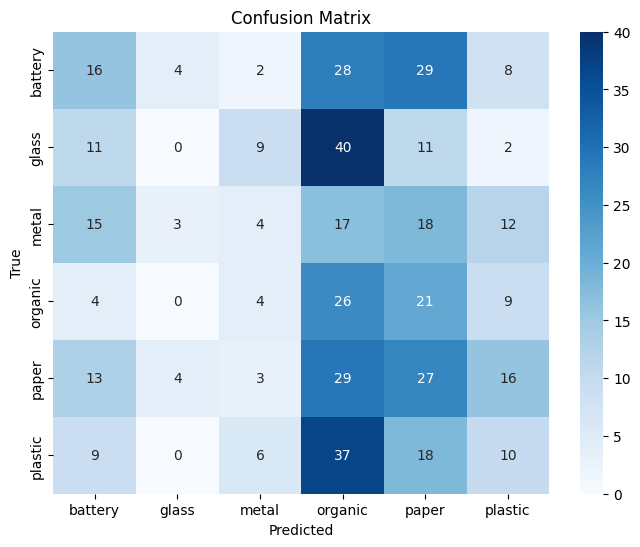

              precision    recall  f1-score   support

     battery       0.24      0.18      0.21        87
       glass       0.00      0.00      0.00        73
       metal       0.14      0.06      0.08        69
     organic       0.15      0.41      0.22        64
       paper       0.22      0.29      0.25        92
     plastic       0.18      0.12      0.15        80

    accuracy                           0.18       465
   macro avg       0.15      0.18      0.15       465
weighted avg       0.16      0.18      0.16       465



In [143]:
predictions = vgg16.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [115]:
vgg19 = load_model(f"{dataset_dir}/garbage-classifier-model/garbage_classifier.vgg_19.h5")

8/8 [==============================] - 291s 36s/step


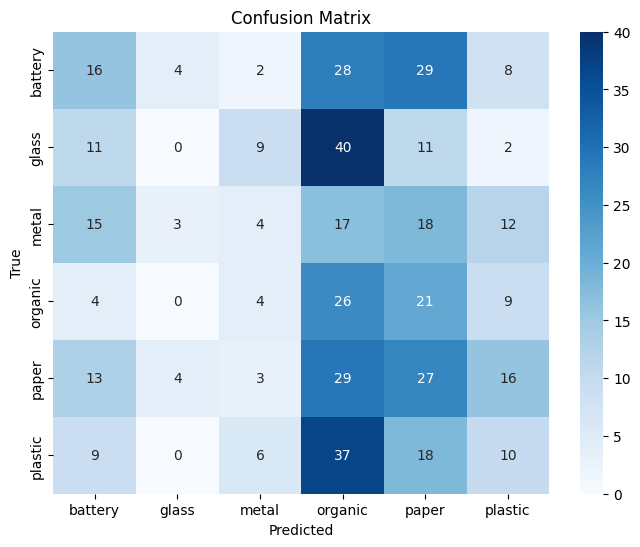

              precision    recall  f1-score   support

     battery       0.24      0.18      0.21        87
       glass       0.00      0.00      0.00        73
       metal       0.14      0.06      0.08        69
     organic       0.15      0.41      0.22        64
       paper       0.22      0.29      0.25        92
     plastic       0.18      0.12      0.15        80

    accuracy                           0.18       465
   macro avg       0.15      0.18      0.15       465
weighted avg       0.16      0.18      0.16       465



In [116]:
predictions = vgg19.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))


In [145]:
model.save(f"{dataset_dir}/garbage-classifier-model/garbage_classifier.resnet50.h5")

In [146]:
resnet50 = load_model(f"{dataset_dir}/garbage-classifier-model/garbage_classifier.resnet50.h5")


8/8 [==============================] - 296s 36s/step


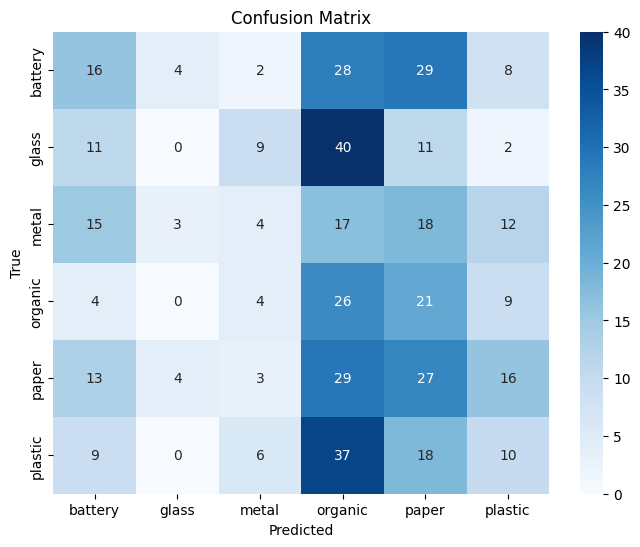

              precision    recall  f1-score   support

     battery       0.24      0.18      0.21        87
       glass       0.00      0.00      0.00        73
       metal       0.14      0.06      0.08        69
     organic       0.15      0.41      0.22        64
       paper       0.22      0.29      0.25        92
     plastic       0.18      0.12      0.15        80

    accuracy                           0.18       465
   macro avg       0.15      0.18      0.15       465
weighted avg       0.16      0.18      0.16       465



In [147]:
predictions = resnet50.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [124]:
model.save(f"{dataset_dir}/garbage-classifier-model/garbage_classifier.resnet152.h5")
resnet152 = load_model(f"{dataset_dir}/garbage-classifier-model/garbage_classifier.resnet152.h5")


8/8 [==============================] - 326s 39s/step


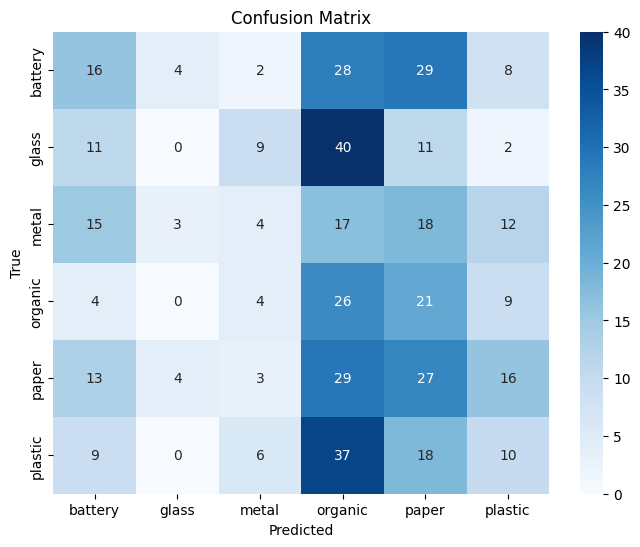

              precision    recall  f1-score   support

     battery       0.24      0.18      0.21        87
       glass       0.00      0.00      0.00        73
       metal       0.14      0.06      0.08        69
     organic       0.15      0.41      0.22        64
       paper       0.22      0.29      0.25        92
     plastic       0.18      0.12      0.15        80

    accuracy                           0.18       465
   macro avg       0.15      0.18      0.15       465
weighted avg       0.16      0.18      0.16       465



In [127]:
predictions = resnet152.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))